# 🧬 SRC-SAT-Topology: A 5-Minute Walkthrough

**Structural Representation Computing (SRC)** allows us to predict the solvability of complex logical problems (3-SAT) by analyzing the **topological spectrum** of their variable interaction graphs, without performing logical search.

> **Key Result:** This model achieves **~84% accuracy** on large-scale benchmarks using only Laplacian eigenvalues.

This notebook demonstrates:
1.  **Core Algorithm**: How we extract spectral fingerprints from SAT formulas.
2.  **Live Demo**: A quick run on small data.
3.  **Benchmark Visualization**: The convergence results from our 30,000-sample stress test.

In [2]:
# Install dependencies if running in Colab
import sys
!{sys.executable} -m pip install python-sat networkx numpy scikit-learn matplotlib

import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- 1. The SRC Core: Spectral Feature Extraction ---
def extract_structure_kernel(n_vars, clauses):
    """
    Transforms a 3-SAT formula into a Variable Interaction Graph (VIG)
    and extracts its Laplacian Spectral Fingerprint.
    """
    # Build Graph
    G = nx.Graph()
    G.add_nodes_from(range(1, n_vars + 1))
    for c in clauses:
        # Connect variables that appear in the same clause
        v = [abs(l) for l in c]
        G.add_edge(v[0], v[1]); G.add_edge(v[1], v[2]); G.add_edge(v[0], v[2])

    # Extract Spectrum (The "Fingerprint")
    try:
        # Normalized Laplacian handles graph scale invariance
        L = nx.normalized_laplacian_matrix(G).todense()
        eigenvalues = np.linalg.eigvalsh(L)
        # We take top-30 eigenvalues as the structural embedding
        fingerprint = sorted(eigenvalues, reverse=True)[:30]
        # Padding if graph is too small
        if len(fingerprint) < 30: fingerprint += [0] * (30 - len(fingerprint))
    except:
        fingerprint = [0] * 30

    return fingerprint

# --- 2. Helper: Generate & Solve 3-SAT ---
def generate_and_solve(n_vars=50):
    ratio = random.uniform(3.5, 5.5) # Critical phase transition area
    n_clauses = int(n_vars * ratio)
    clauses = [[random.randint(1, n_vars) * random.choice([1, -1]) for _ in range(3)] for _ in range(n_clauses)]

    # Get Ground Truth (Label) using a Solver
    g = Glucose3()
    for c in clauses: g.add_clause(c)
    is_sat = g.solve()
    g.delete()

    return clauses, 1 if is_sat else 0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.7 MB/s eta 0:00:00


In [3]:
print("🚀 Running Live Demo (N=500 samples)...")

X, y = [], []
for _ in range(500):
    clauses, label = generate_and_solve(n_vars=50)
    features = extract_structure_kernel(50, clauses)
    X.append(features)
    y.append(label)

# Train a simple classifier
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test))

print(f"✅ Live Demo Result: {acc:.2%} Accuracy")
print("   (Note: Accuracy increases with sample size, see below)")

🚀 Running Live Demo (N=500 samples)...
✅ Live Demo Result: 77.00% Accuracy
   (Note: Accuracy increases with sample size, see below)


📊 Displaying Final Convergence Plot:


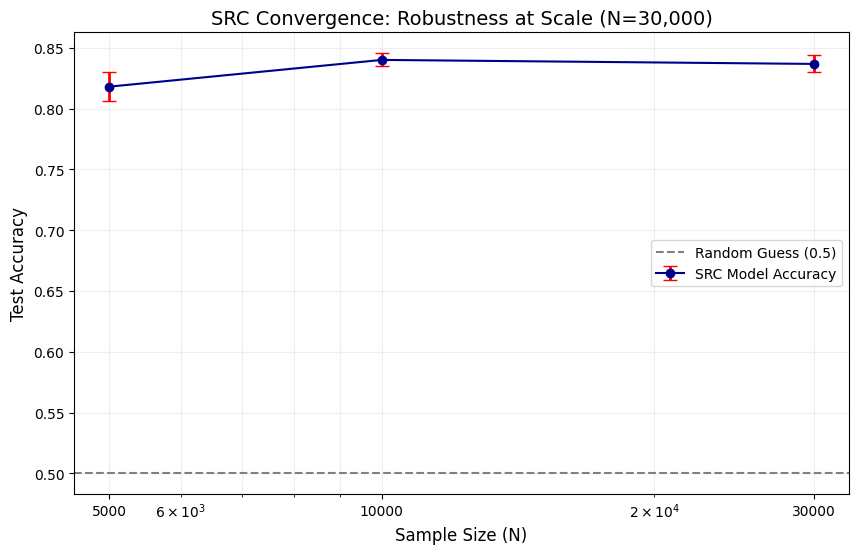

In [4]:
# --- 3. Visualization of Large-Scale Results ---
# Data from the full experiment (N=30,000, 10 Rounds)
# We hardcode the final results here to save time for the viewer.

sample_sizes = [5000, 10000, 30000]
mean_accs =    [0.8180, 0.8400, 0.8367]  # From our experiment logs
std_devs =     [0.0118, 0.0054, 0.0070]

plt.figure(figsize=(10, 6))

# Plot Error Bars
plt.errorbar(sample_sizes, mean_accs, yerr=std_devs,
             fmt='-o', capsize=5, color='darkblue', ecolor='red',
             elinewidth=2, label='SRC Model Accuracy')

# Plot Baseline
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess (0.5)')

# Styling
plt.xscale('log')
plt.xticks(sample_sizes, sample_sizes)
plt.xlabel("Sample Size (N)", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("SRC Convergence: Robustness at Scale (N=30,000)", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

print("📊 Displaying Final Convergence Plot:")
plt.show()